In [ ]:
# Imported pandas and numpy for data analysis / Veri analizi için pandas ve numpy içe aktarıldı
import pandas as pd
import numpy as np

# Read dataset from the data folder / Veri seti data klasöründen okundu
data = pd.read_excel("C:/Users/harun/Desktop/Projects/customer-segmentation-RFM-project/data/Online Retail Data Set.xlsx")

# Checked the shape to understand the data size / Veri boyutunu anlamak için shape kontrol edildi
print("Dataset shape:", data.shape)

# Displayed the first few rows to review structure / Yapıyı gözden geçirmek için ilk birkaç satır gösterildi
data.head()


Dataset shape: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [6]:
# Removed rows where CustomerID was missing / CustomerID eksik olan satırlar kaldırıldı
data = data.dropna(subset=["CustomerID"])

# Removed invoices that were cancellations (started with 'C') / 'C' ile başlayan iptal faturaları kaldırıldı
data = data[~data["InvoiceNo"].astype(str).str.startswith("C")]

# Removed rows with non-positive quantities / Negatif veya sıfır miktarlı satırlar silindi
data = data[data["Quantity"] > 0]

# Created a new column for total price / Toplam fiyat sütunu oluşturuldu
data["TotalPrice"] = data["Quantity"] * data["UnitPrice"]

# Checked the cleaned dataset / Temizlenmiş veri seti kontrol edildi
print("Cleaned dataset shape:", data.shape)
data.head()


Cleaned dataset shape: (397924, 9)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [7]:
# Converted InvoiceDate to datetime format / InvoiceDate sütunu datetime tipine çevrildi
data["InvoiceDate"] = pd.to_datetime(data["InvoiceDate"])

# Determined the latest date in the dataset / Veri setindeki en son tarih belirlendi
reference_date = data["InvoiceDate"].max()

# Calculated Recency for each customer / Her müşteri için Recency (gün farkı) hesaplandı
recency_df = data.groupby("CustomerID")["InvoiceDate"].max().reset_index()
recency_df["Recency"] = (reference_date - recency_df["InvoiceDate"]).dt.days

# Displayed sample Recency results / Örnek Recency sonuçları gösterildi
recency_df.head()


,CustomerID,InvoiceDate,Recency
0,12346.0,2011-01-18 10:01:00,325
1,12347.0,2011-12-07 15:52:00,1
2,12348.0,2011-09-25 13:13:00,74
3,12349.0,2011-11-21 09:51:00,18
4,12350.0,2011-02-02 16:01:00,309


In [ ]:
# Calculated Frequency for each customer / Her müşteri için sıklık hesaplandı
frequency_df = data.groupby("CustomerID")["InvoiceNo"].nunique().reset_index()
frequency_df.rename(columns={"InvoiceNo": "Frequency"}, inplace=True)

# Displayed sample Frequency results / Örnek Frequency sonuçları gösterildi
frequency_df.head()


,CustomerID,Frequency
0,12346.0,1
1,12347.0,7
2,12348.0,4
3,12349.0,1
4,12350.0,1


In [9]:
# Calculated Monetary value for each customer / Her müşteri için toplam harcama (Monetary) hesaplandı
monetary_df = data.groupby("CustomerID")["TotalPrice"].sum().reset_index()
monetary_df.rename(columns={"TotalPrice": "Monetary"}, inplace=True)

# Displayed sample Monetary results / Örnek Monetary sonuçları gösterildi
monetary_df.head()


,CustomerID,Monetary
0,12346.0,77183.60
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [10]:
# Merged Recency, Frequency, and Monetary dataframes into a single RFM table
# Recency, Frequency ve Monetary tabloları tek bir RFM tablosunda birleştirildi
rfm = recency_df.merge(frequency_df, on="CustomerID").merge(monetary_df, on="CustomerID")

# Displayed the combined RFM table
# Birleştirilmiş RFM tablosu gösterildi
rfm.head()


,CustomerID,InvoiceDate,Recency,Frequency,Monetary
0,12346.0,2011-01-18 10:01:00,325,1,77183.60
1,12347.0,2011-12-07 15:52:00,1,7,4310.00
2,12348.0,2011-09-25 13:13:00,74,4,1797.24
3,12349.0,2011-11-21 09:51:00,18,1,1757.55
4,12350.0,2011-02-02 16:01:00,309,1,334.40


In [11]:
# Sorted and ranked Frequency and Monetary before scoring / Frequency ve Monetary sıralandı ve rank uygulandı
rfm["R_Rank"] = rfm["Recency"].rank(method="first", ascending=True)
rfm["F_Rank"] = rfm["Frequency"].rank(method="first", ascending=False)
rfm["M_Rank"] = rfm["Monetary"].rank(method="first", ascending=False)

# Assigned quintile scores after ranking / Sıralama sonrası beşlik dilim skorları atandı
rfm["R_Score"] = pd.qcut(rfm["R_Rank"], 5, labels=[5,4,3,2,1])
rfm["F_Score"] = pd.qcut(rfm["F_Rank"], 5, labels=[1,2,3,4,5])
rfm["M_Score"] = pd.qcut(rfm["M_Rank"], 5, labels=[1,2,3,4,5])

# Combined R, F, and M scores into a single string / R, F ve M skorları tek bir string olarak birleştirildi
rfm["RFM_Segment"] = rfm["R_Score"].astype(str) + rfm["F_Score"].astype(str) + rfm["M_Score"].astype(str)

# Calculated an overall RFM score / Genel bir RFM skoru hesaplandı
rfm["RFM_Score"] = rfm[["R_Score", "F_Score", "M_Score"]].astype(int).sum(axis=1)

# Displayed RFM scores / RFM skorları gösterildi
rfm[["CustomerID", "Recency", "Frequency", "Monetary", "RFM_Segment", "RFM_Score"]].head(10)


,CustomerID,Recency,Frequency,Monetary,RFM_Segment,RFM_Score
0,12346.0,325,1,77183.60,141,6
1,12347.0,1,7,4310.00,511,7
2,12348.0,74,4,1797.24,222,6
3,12349.0,18,1,1757.55,442,10
4,12350.0,309,1,334.40,144,9
5,12352.0,35,8,2506.04,311,5
6,12353.0,203,1,89.00,145,10
7,12354.0,231,1,1079.40,142,7
8,12355.0,213,1,459.40,144,9
9,12356.0,22,3,2811.43,421,7


In [12]:
# Assigned customer segments based on RFM_Score ranges
# RFM_Score aralıklarına göre müşteri segmentleri atandı
def segment_customer(score):
    if score >= 13:
        return "Champions"
    elif score >= 10:
        return "Loyal Customers"
    elif score >= 7:
        return "Potential Loyalist"
    elif score >= 4:
        return "Needs Attention"
    else:
        return "At Risk / Lost"

rfm["Segment"] = rfm["RFM_Score"].apply(segment_customer)

# Displayed sample of final RFM table with segments
# Segment isimleriyle son RFM tablosu gösterildi
rfm[["CustomerID", "Recency", "Frequency", "Monetary", "RFM_Segment", "RFM_Score", "Segment"]].head(10)


,CustomerID,Recency,Frequency,Monetary,RFM_Segment,RFM_Score,Segment
0,12346.0,325,1,77183.60,141,6,Needs Attention
1,12347.0,1,7,4310.00,511,7,Potential Loyalist
2,12348.0,74,4,1797.24,222,6,Needs Attention
3,12349.0,18,1,1757.55,442,10,Loyal Customers
4,12350.0,309,1,334.40,144,9,Potential Loyalist
5,12352.0,35,8,2506.04,311,5,Needs Attention
6,12353.0,203,1,89.00,145,10,Loyal Customers
7,12354.0,231,1,1079.40,142,7,Potential Loyalist
8,12355.0,213,1,459.40,144,9,Potential Loyalist
9,12356.0,22,3,2811.43,421,7,Potential Loyalist


C:\Users\harun\AppData\Local\Temp\ipykernel_6628\4049365521.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Segment", y="Count", data=segment_counts, palette="viridis")


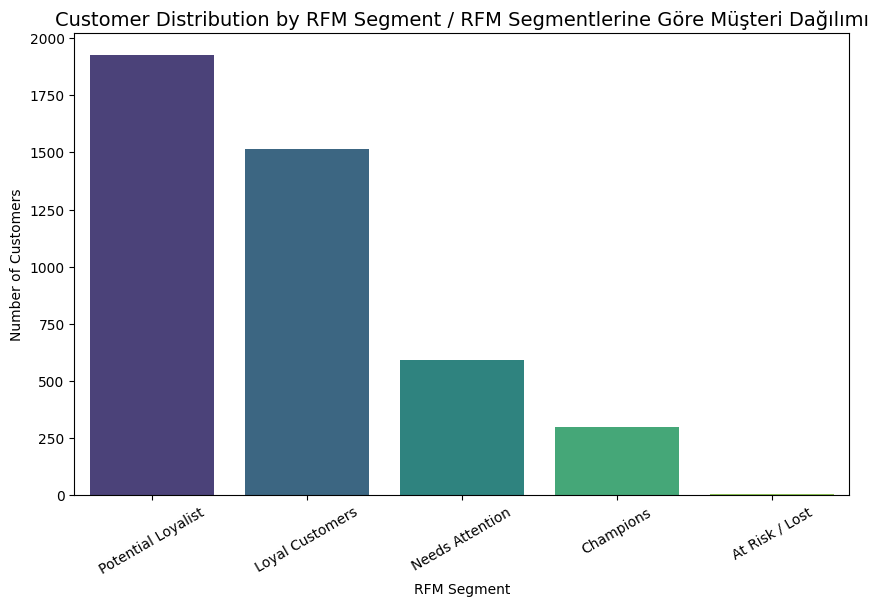

In [13]:
# Imported matplotlib and seaborn for visualization / Görselleştirme için matplotlib ve seaborn içe aktarıldı
import matplotlib.pyplot as plt
import seaborn as sns

# Counted customers per segment / Her segmentteki müşteri sayısı sayıldı
segment_counts = rfm["Segment"].value_counts().reset_index()
segment_counts.columns = ["Segment", "Count"]

# Created a bar chart to visualize segment distribution / Segment dağılımını göstermek için çubuk grafik oluşturuldu
plt.figure(figsize=(10,6))
sns.barplot(x="Segment", y="Count", data=segment_counts, palette="viridis")

# Added title and labels / Başlık ve etiketler eklendi
plt.title("Customer Distribution by RFM Segment / RFM Segmentlerine Göre Müşteri Dağılımı", fontsize=14)
plt.xlabel("RFM Segment")
plt.ylabel("Number of Customers")

# Rotated x labels for readability / X ekseni etiketleri okunabilir hale getirildi
plt.xticks(rotation=30)

# Displayed the plot / Grafik gösterildi
plt.show()


In [ ]:
import pandas as pd
import numpy as np

# Read the original dataset again / Veri setini yeniden okudum
data = pd.read_excel(r"C:\Users\harun\Desktop\Projects\customer-segmentation-RFM-project\data\Online Retail Data Set.xlsx")

# Clean the data (same steps as before) / Veriyi tenizledim (önceki adımlarla aynı)
data = data[data["CustomerID"].notnull()]
data = data[~data["InvoiceNo"].astype(str).str.startswith("C")]
data["TotalPrice"] = data["Quantity"] * data["UnitPrice"]

import datetime as dt
snapshot_date = data["InvoiceDate"].max() + dt.timedelta(days=1)
rfm = data.groupby("CustomerID").agg({
    "InvoiceDate": lambda x: (snapshot_date - x.max()).days,
    "InvoiceNo": "nunique",
    "TotalPrice": "sum"
}).reset_index()

rfm.columns = ["CustomerID", "Recency", "Frequency", "Monetary"]

# Exported RFM data prepared specifically for Power BI visualization
# Power BI'da görselleştirme yapmak için özel olarak hazırlanmış RFM verisi
# (Includes segment definitions such as Champions, Loyal, Potential Loyalist, etc.)
# (Şampiyonlar, Sadık, Potansiyel Sadık vb. segment tanımlarını içerir)

rfm['R'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1])
rfm['F'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5])
rfm['M'] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5])

rfm['RFM_Score'] = rfm[['R','F','M']].sum(axis=1)
rfm['RFM_Segment'] = rfm['R'].astype(str) + rfm['F'].astype(str) + rfm['M'].astype(str)

# Define customer segments based on RFM score / RFM skorlarına göre müşteri ayrımları
def segment(row):
    score = row['RFM_Score']
    if score >= 12:
        return 'Champions'
    elif score >= 9:
        return 'Loyal Customers'
    elif score >= 6:
        return 'Potential Loyalist'
    elif score >= 4:
        return 'Needs Attention'
    else:
        return 'At Risk / Lost'

rfm['Segment'] = rfm.apply(segment, axis=1)


In [2]:
# Exported RFM table to CSV for Power BI visualization
# RFM tablosu Power BI görselleştirmesi için CSV olarak dışa aktarıldı
rfm.to_csv(r"C:\Users\harun\Desktop\Projects\customer-segmentation-RFM-project\data\rfm_table.csv", index=False)